In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset
df = pd.read_csv('STML.csv', nrows=10000, encoding='utf-8-sig')

# Extract dates before dropping the column
dates = df['Date']

# Define target variables (y) - BEFORE dropping
y_10cm = df['SDT10']
y_20cm = df['SDT20']
y_50cm = df['SDT50']

# Drop unwanted features (including 'Date' and target variables)
df = df.drop(['Date', 'SDT10', 'SDT20', 'SDT50'], axis=1)

# Define features(X)
X = df  # Now X doesn't contain 'Date' or target variables

In [ ]:
# Combine the target variables into a single DataFrame or array if needed
y = pd.DataFrame({'SDT10': y_10cm, 'SDT20': y_20cm, 'SDT50': y_50cm})

In [ ]:
df.head()

,Tmax,Tmin,STS,ET,WS,RAD,SS,H
0,13.7,3.8,25.4,1.4,0.5,259.0,8.2,86.0
1,12.0,4.0,16.0,1.0,1.6,130.0,0.1,91.0
2,10.5,8.5,10.5,1.0,2.3,10.0,0.0,94.0
3,14.5,8.6,18.8,1.4,0.8,247.0,7.2,82.0
4,14.5,3.4,19.6,0.5,0.6,178.0,3.5,92.0


In [ ]:
X.head()

,Tmax,Tmin,STS,ET,WS,RAD,SS,H
0,13.7,3.8,25.4,1.4,0.5,259.0,8.2,86.0
1,12.0,4.0,16.0,1.0,1.6,130.0,0.1,91.0
2,10.5,8.5,10.5,1.0,2.3,10.0,0.0,94.0
3,14.5,8.6,18.8,1.4,0.8,247.0,7.2,82.0
4,14.5,3.4,19.6,0.5,0.6,178.0,3.5,92.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tmax    3287 non-null   float64
 1   Tmin    3287 non-null   float64
 2   STS     3287 non-null   float64
 3   ET      3287 non-null   float64
 4   WS      3287 non-null   float64
 5   RAD     3287 non-null   float64
 6   SS      3287 non-null   float64
 7   H       3287 non-null   float64
dtypes: float64(8)
memory usage: 205.6 KB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'X' is your feature DataFrame and 'y' is your target variable(s)
# Split the data into training (70%), validation (15%), and testing (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and testing data using the fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM input (if needed)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
# Install necessary libraries
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Attention
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
def create_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Stacked LSTM layers with Dropout
    lstm_out = LSTM(128, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(64, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(32, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])

    # Dense layers with L2 regularization
    dense_out1 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out1 = Dropout(0.2)(dense_out1)
    output1 = Dense(1, name='ST_10cm')(dense_out1)

    dense_out2 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out2 = Dropout(0.2)(dense_out2)
    output2 = Dense(1, name='ST_20cm')(dense_out2)

    dense_out3 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out3 = Dropout(0.2)(dense_out3)
    output3 = Dense(1, name='ST_50cm')(dense_out3)

    model = Model(inputs=input_layer, outputs=[output1, output2, output3])
    return model

# Create the model
model = create_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_reshaped, [y_train['SDT10'], y_train['SDT20'], y_train['SDT50']],
                    validation_data=(X_val_reshaped, [y_val['SDT10'], y_val['SDT20'], y_val['SDT50']]),
                    epochs=200, batch_size=32, callbacks=[early_stopping])


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1416.5016

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 1418.4919 - val_loss: 1441.7423
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1453.7565 - val_loss: 1431.9976
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1436.0887 - val_loss: 1394.2290
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1375.8488 - val_loss: 1218.5372
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1187.1946 - val_loss: 960.2177
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 919.5538 - val_loss: 763.7057
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 745.1526 - val_loss: 624.5622
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 617.5331 - val_loss: 518.6956
Epoch 9/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 526.8123 - val_loss: 438.8367
Epoch 10/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 443.5160 - val_loss: 376.3659
Epoch 11/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 375.4181 - val_loss: 328.7321
Epoch 12/200
7

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error


# Evaluate the model on the training set
y_train_pred = model.predict(X_train_reshaped)
# Evaluate the model on the test set
y_test_pred = model.predict(X_test_reshaped)
# Evaluate the model on the validation set
y_val_pred = model.predict(X_val_reshaped)

# Calculate metrics for each output
outputs = ['SDT10', 'SDT20', 'SDT50']
for i, output in enumerate(outputs):
    print(f"Metrics for {output}:")

    # Training set metrics
    print("Training Set:")
    print("R2:", r2_score(y_train[output], y_train_pred[i].flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(y_train[output], y_train_pred[i].flatten())))
    print("MSE:", mean_squared_error(y_train[output], y_train_pred[i].flatten()))

    # Test set metrics
    print("Test Set:")
    print("R2:", r2_score(y_test[output], y_test_pred[i].flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(y_test[output], y_test_pred[i].flatten())))
    print("MSE:", mean_squared_error(y_test[output], y_test_pred[i].flatten()))
    print("----")

    # Val set metrics
    print("Validatio Set:")
    print("R2:", r2_score(y_val[output], y_val_pred[i].flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(y_val[output], y_val_pred[i].flatten())))
    print("MSE:", mean_squared_error(y_val[output], y_val_pred[i].flatten()))
    print("----")



 1/72 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Metrics for SDT10:
Training Set:
R2: 0.9574995801379514
RMSE: 1.752785657659357
MSE: 3.0722575616963446
Test Set:
R2: 0.9548955978318671
RMSE: 1.742745965669536
MSE: 3.0371635008574436
----
Validatio Set:
R2: 0.9492799791326259
RMSE: 1.887853761185748
MSE: 3.5639918236231756
----
Metrics for SDT20:
Training Set:
R2: 0.9402241604162139
RMSE: 1.896545659058783
MSE: 3.5968854368947136
Test Set:
R2: 0.9357569032299101
RMSE: 1.9145723294057235
MSE: 3.6655872045260582
----
Validatio Set:
R2: 0.932078419812447
RMSE: 1.9877733852302024
MSE: 3.9512430310295388
----
Metrics for SDT50:
Training Set:
R2: 0.8558338374415335
RMSE: 2.562984027372347
MSE: 6.5688871245657765
Test Set:
R2: 0.8441820540017646
RMSE: 2.645579274058037
MSE: 6.9990896953254484
----
Validatio Set:
R2: 0.8458670197125115
RMSE: 2.6096627739068374
MSE: 6.810339793515128
----


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.8 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
def predict_function(X):
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    return model.predict(X_reshaped)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 64s 3

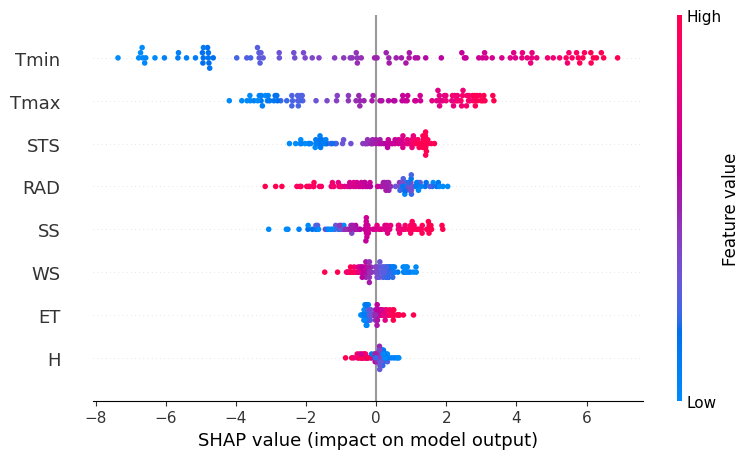

In [ ]:


# Define a function to reshape input and predict using your LSTM model
def predict_function(X):
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    # Return the prediction for the first output (index 0)
    return model.predict(X_reshaped)[0]




# Create a SHAP explainer using your LSTM model and training data
explainer = shap.KernelExplainer(predict_function, X_train_scaled)

# Sample from the test set for explanations
X_test_sample = shap.sample(X_test_scaled, 100)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Reshape SHAP values to match the shape of the test sample
shap_values_reshaped = np.array(shap_values).reshape(X_test_sample.shape)

# Plot the SHAP summary plot
plt.figure()
shap.summary_plot(shap_values_reshaped, X_test_sample, feature_names=X.columns)
plt.show()

In [ ]:
import pandas as pd

# Assuming you have shap_values_reshaped and X_test_sample
# Create a pandas DataFrame from the SHAP values
df_shap = pd.DataFrame(shap_values_reshaped, columns=X.columns)

# Optionally, add the original feature values to the DataFrame
df_shap = pd.concat([df_shap, pd.DataFrame(X_test_sample, columns=X.columns)], axis=1)

# Export the DataFrame to a CSV file
df_shap.to_csv('shap_valuestest.csv', index=False)

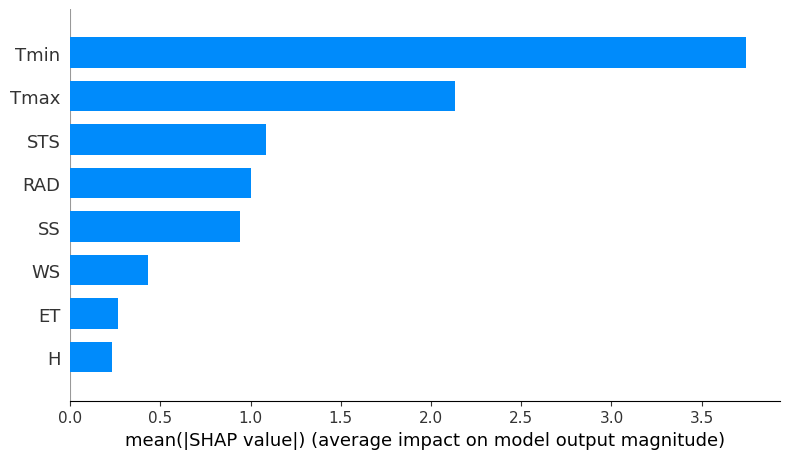

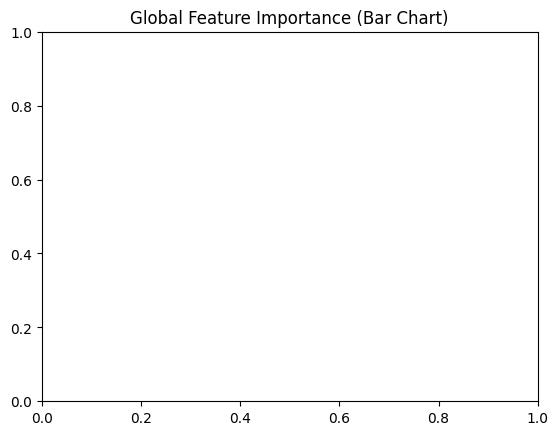

In [ ]:
# Bar chart for global feature importance based on mean absolute SHAP values
plt.figure()
shap.summary_plot(shap_values_reshaped, X_test_sample, feature_names=X.columns, plot_type="bar")
plt.title("Global Feature Importance (Bar Chart)")
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
18257/18257 ━━━━━━━━━━━━━━━━━━━━ 54s 3

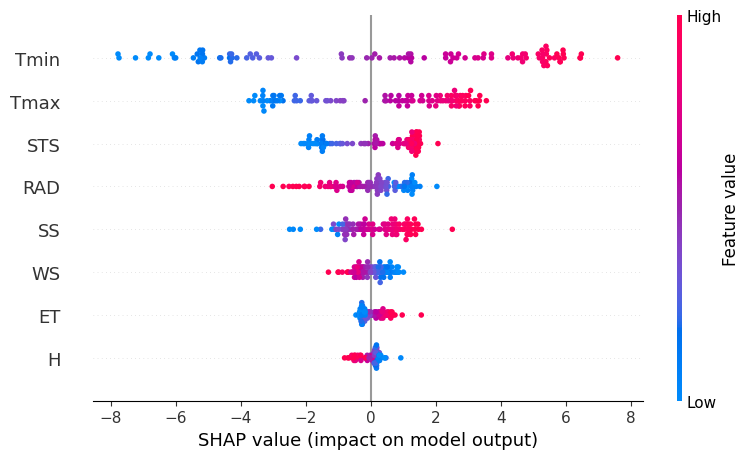

In [ ]:

# Define a function to reshape input and predict using your LSTM model
def predict_function(X):
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    # Return the prediction for the first output (index 0)
    return model.predict(X_reshaped)[0]

# Create a SHAP explainer using your LSTM model and training data
explainer = shap.KernelExplainer(predict_function, X_train_scaled)

# Sample from the test set for explanations
X_val_sample = shap.sample(X_val_scaled, 100)

# Calculate SHAP values
shap_values = explainer.shap_values(X_val_sample)

# Reshape SHAP values to match the shape of the test sample
shap_values_reshaped = np.array(shap_values).reshape(X_val_sample.shape)

# Plot the SHAP summary plot
plt.figure()
shap.summary_plot(shap_values_reshaped, X_val_sample, feature_names=X.columns)
plt.show()

In [ ]:
import pandas as pd

# Assuming you have shap_values_reshaped and X_test_sample
# Create a pandas DataFrame from the SHAP values
df_shap = pd.DataFrame(shap_values_reshaped, columns=X.columns)

# Optionally, add the original feature values to the DataFrame
df_shap = pd.concat([df_shap, pd.DataFrame(X_val_sample, columns=X.columns)], axis=1)

# Export the DataFrame to a CSV file
df_shap.to_csv('shap_values.csv', index=False)

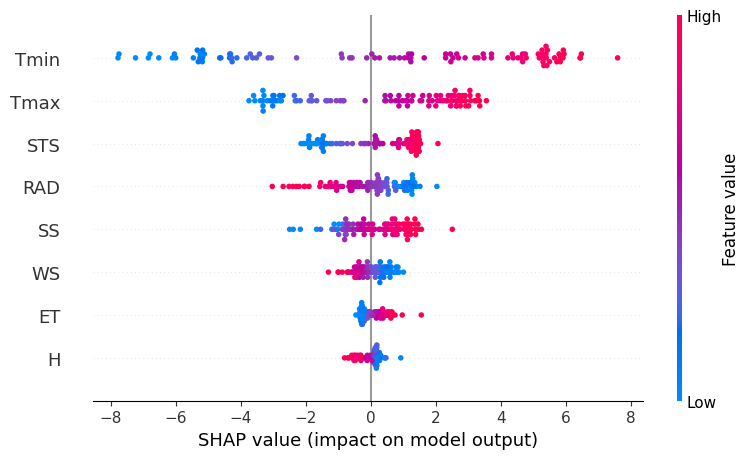

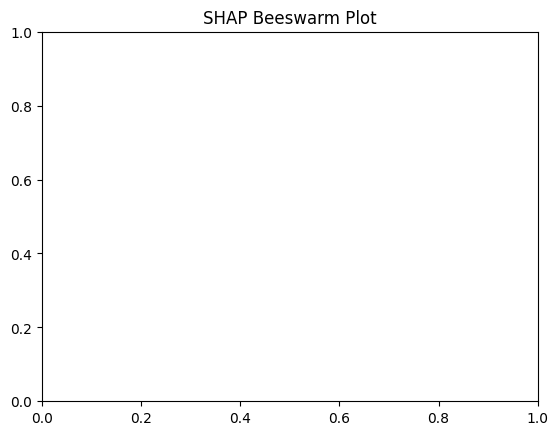

In [ ]:
# SHAP Beeswarm plot (Summary plot with dots)
plt.figure()
shap.summary_plot(shap_values_reshaped, X_val_sample, feature_names=X.columns, plot_type="dot")
plt.title("SHAP Beeswarm Plot")
plt.show()


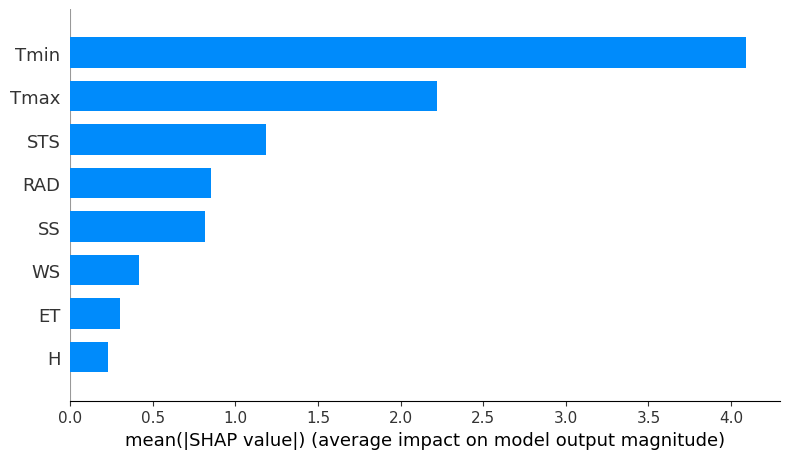

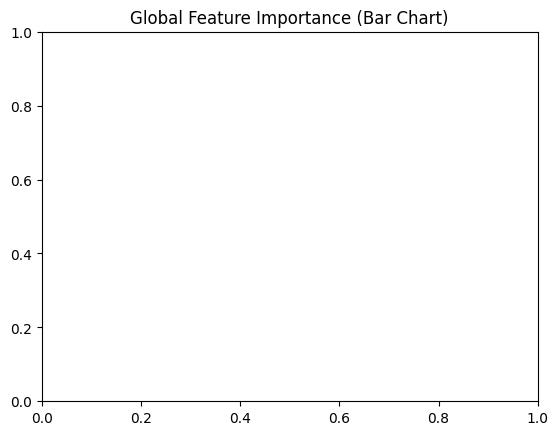

In [ ]:
# Bar chart for global feature importance based on mean absolute SHAP values
plt.figure()
shap.summary_plot(shap_values_reshaped, X_val_sample, feature_names=X.columns, plot_type="bar")
plt.title("Global Feature Importance (Bar Chart)")
plt.show()


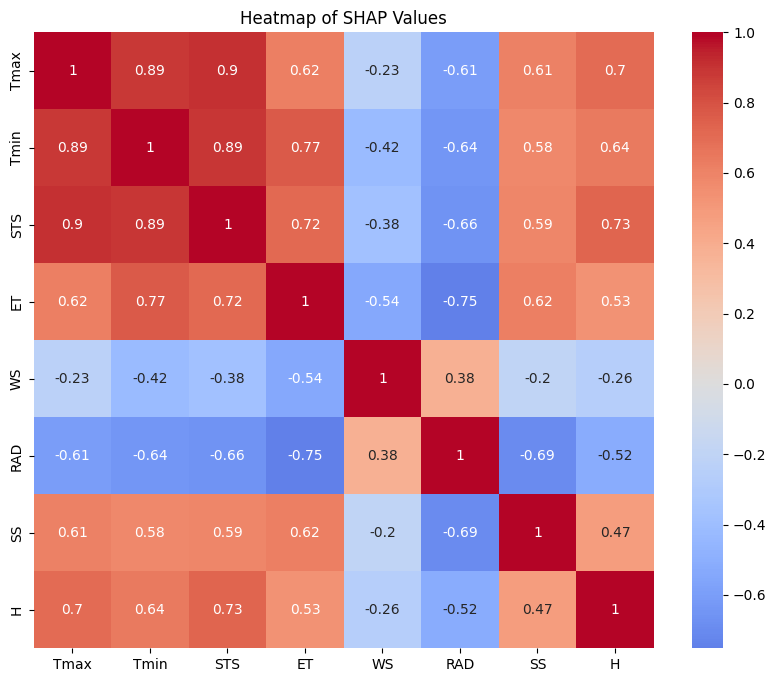

In [ ]:
import seaborn as sns
import pandas as pd

# Convert SHAP values to a DataFrame for easier manipulation
shap_df = pd.DataFrame(shap_values_reshaped, columns=X.columns)

# Create heatmap of SHAP values correlations
plt.figure(figsize=(10, 8))
sns.heatmap(shap_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap of SHAP Values")
plt.show()


<Figure size 640x480 with 0 Axes>

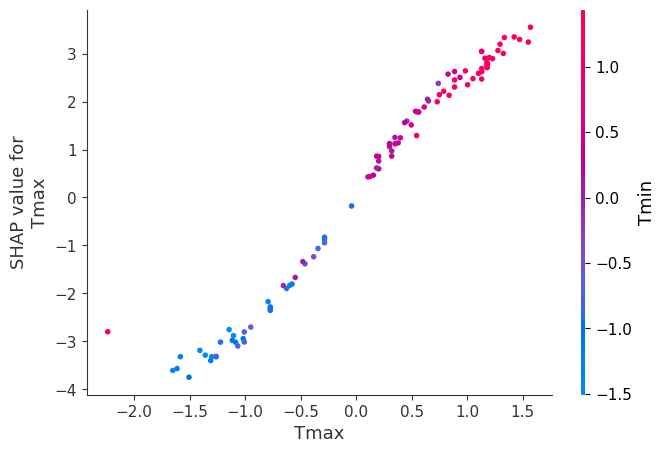

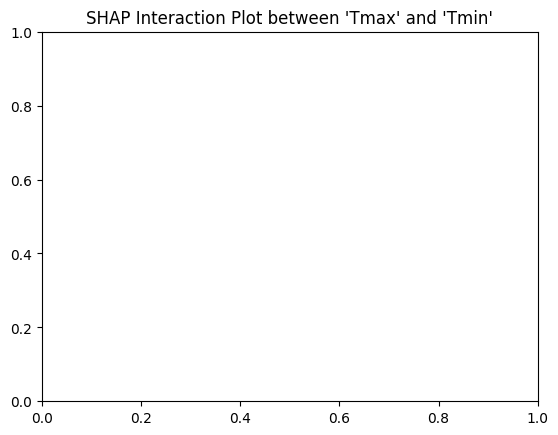

In [ ]:
# Interaction plot between two features (e.g., 'Tmax' and 'Tmin')
plt.figure()
shap.dependence_plot('Tmax', shap_values_reshaped, X_val_sample, feature_names=X.columns, interaction_index='Tmin')
plt.title("SHAP Interaction Plot between 'Tmax' and 'Tmin'")
plt.show()
